In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_X,train_Y), (test_X,test_Y) = boston_housing.load_data()

In [3]:
print('Shape of training data is:', train_X.shape)
print('Shape of testing data is:', test_X.shape)

Shape of training data is: (404, 13)
Shape of testing data is: (102, 13)


In [4]:
#what are datapoints like?
print(train_X[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [5]:
#we see features are on different scale altogether!
#Neural networks work better if we do data normalization before operating on it
mean = train_X.mean(axis=0)
std = train_X.std(axis=0) #along the axis of all examples
#use same mean and std calculated from training data on testing data!
train_X = (train_X - mean)/std
test_X = (test_X - mean)/std

In [6]:
def get_model( activation='relu', hidden_layer_sizes=[128] ):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(13,)))
    for hlayer in hidden_layer_sizes[1:]:
        model.add(Dense(hlayer, activation=activation))
    model.add(Dense(1)) #no activation - we don't want to limit our output
    model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])
    return model

def fit_and_plot( activation, hidden_layer_sizes, train_X, train_Y, test_X, test_Y ):
    total_partitions = 5
    partition_size = train_X.shape[0]//total_partitions
    epochs = 100
    val_maes= []
    train_maes = []
    train_mae_history = []
    val_mae_history = []
    for i in range( total_partitions ): #k-fold partition - very few datapoints, to really make use of validation data, we should use k-fold validation
        model = get_model(activation, hidden_layer_sizes )
        
        val_X = train_X[ i*partition_size:(i+1)*partition_size]
        val_Y = train_Y[ i*partition_size:(i+1)*partition_size]
        training_X = np.concatenate( [ train_X[ :i*partition_size],
                  train_X[(i+1)*partition_size:] ], axis=0 )
        training_Y = np.concatenate( [ train_Y[ :i*partition_size],
                  train_Y[(i+1)*partition_size:] ], axis=0 )
        history = model.fit(training_X, training_Y, epochs=epochs, verbose=0, batch_size=1, validation_data=(val_X,val_Y))
        val_mae = model.evaluate(val_X, val_Y, verbose=0)[1]
        val_maes.append(val_mae)
        train_mae = model.evaluate(training_X, training_Y, verbose=0)[1]
        train_maes.append(train_mae)
        train_mae_history.append(history.history['mae'])
        val_mae_history.append(history.history['val_mae'])
    
    average_val_mae = np.mean(val_maes)
    print('Average validation mae is %3.2f' % (average_val_mae))
    average_train_mae = np.mean(train_maes)
    print('Average training mae is %3.2f' % (average_train_mae))
    
    val_mae_history = np.mean(val_mae_history, axis=0)
    train_mae_history = np.mean(train_mae_history, axis=0)
    
    plt.figure(figsize=(8,6))
    plt.plot(range(1, epochs+1), val_mae_history, 'b', label='Validation mean absolute error')
    plt.plot(range(1, epochs+1), train_mae_history, 'r', label='Training mean absolute error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

Average validation mae is 2.26
Average training mae is 1.35


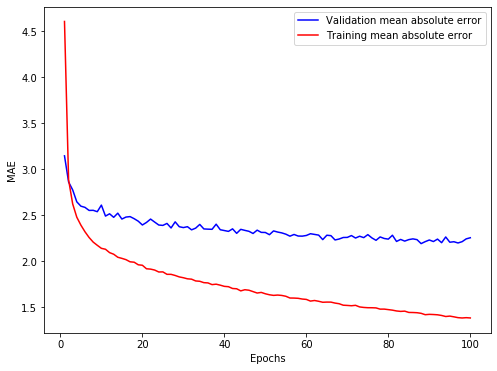

In [7]:
fit_and_plot('relu', [128,64,32], train_X, train_Y, test_X, test_Y)

Average validation mae is 2.41
Average training mae is 1.90


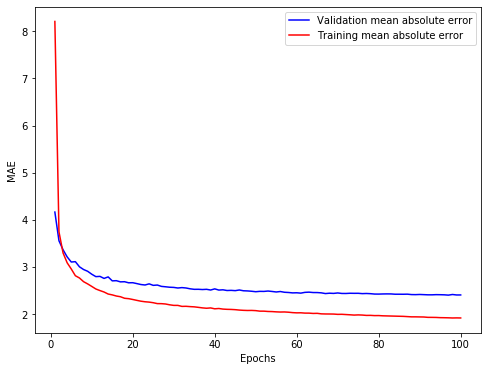

In [8]:
fit_and_plot('relu', [64,32], train_X, train_Y, test_X, test_Y)

Average validation mae is 3.14
Average training mae is 2.89


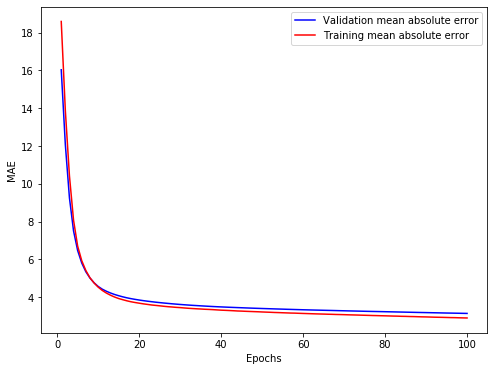

In [9]:
fit_and_plot('relu', [32], train_X, train_Y, test_X, test_Y)

Average validation mae is 3.57
Average training mae is 3.33


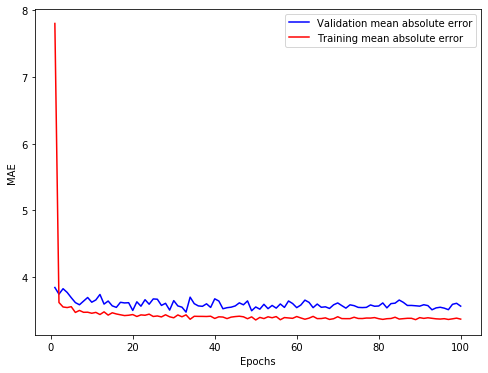

In [10]:
fit_and_plot(None, [128,64,32], train_X, train_Y, test_X, test_Y)

Average validation mae is 3.55
Average training mae is 3.32


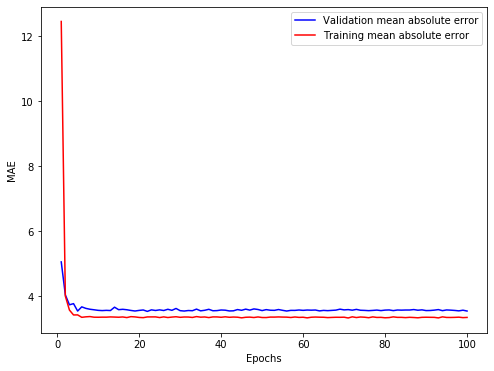

In [11]:
fit_and_plot(None, [64,32], train_X, train_Y, test_X, test_Y)

Average validation mae is 3.51
Average training mae is 3.30


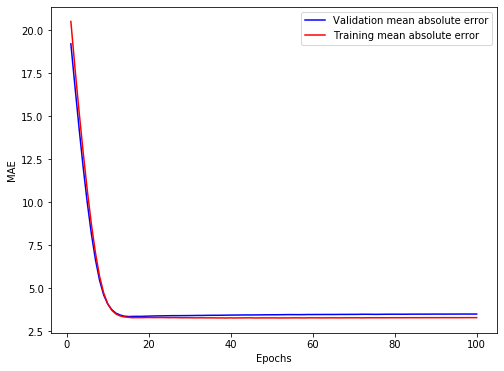

In [12]:
fit_and_plot(None, [32], train_X, train_Y, test_X, test_Y)

#### What do we learn? If we increase number of layers in the model, we observe overfitting of data! This is expected. Also if we don't use any activation function, the resulting function is really a linear equation, we achieve low accuracy at the end of same of number of epochs! Generally we would want to go through these models and hyper tuning the parameters to come up with model that doesn't overfit the data, and is proper representation of the data as well